# Finite Basis Kolmogorov-Arnold Network (FBKANs) in Neuromancer

This tutorial demonstrates the use of Finite Basis Kolmogorov-Arnold Networks (FBKANs) for learning noisy data via domain decomposition.

### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[4] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[5] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main


### Install Neuromancer
(Note: you can skip this step if running locally)

In [1]:
# # Clone the specific branch of the repository
# !git clone --branch feature/fbkans https://github.com/pnnl/neuromancer.git

# # Navigate to the repository directory
# %cd neuromancer

# # Install the repository using pip install .
# !pip install .


### Import dependencies

In [2]:
import torch
import numpy as np
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.callbacks import Callback
from neuromancer.loggers import LossLogger


### Configure device and RNG seed

In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generate data

We will use the function below to generate data from the function:

$$
f(x) = \sin(4 \pi x^2) \sin(6 \pi y^2)
$$

where $x, y \in [0,1]^2$. To simulate noise in the training data, random Gaussian noise with a standard deviation of 0.05 is added to the training labels.


In [43]:
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        
        
    train_label = f(train_input)
    test_label = f(test_input)
        
        
    def normalize(data, mean, std):
            return (data-mean)/std
            sd
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

In [44]:
# Function to sample from
f = lambda x: ((torch.sin(4*torch.pi*(x[:,[0]]**2))))*((torch.sin(6*torch.pi*(x[:,[1]]**2))))

# Create dataset
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=1000)

# Extract data directly as PyTorch tensors
X_train = dataset['train_input']
X_test = dataset['test_input']
y_train = dataset['train_label']
y_test = dataset['test_label']
y_clean = y_train.clone()

# Add 5% noise to the training data labels
y_train += 0.05 * torch.randn(y_train.shape)


In [45]:
# DictDatasets
train_data = DictDataset({'X': dataset['train_input'].to(device), 'z':dataset['train_label'].to(device)}, name='train')
dev_data = DictDataset({'X': dataset['test_input'].to(device), 'z':dataset['test_label'].to(device)}, name='dev')

# torch dataloaders
batch_size = train_data.datadict['X'].shape[0]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

### Create KAN blocks in Neuromancer

In [73]:
# Neural nets to solve the PDE problem

net_fbkan = blocks.KANBlock(insize=2,outsize=1, hsizes=[5], num_domains=4, grid_sizes=[5],
                            spline_order=3, grid_eps=0.02, scale_base=1.0).to(device)

net_kan = blocks.KANBlock(insize=2,outsize=1, hsizes=[5], num_domains=1, grid_sizes=[5],
                            spline_order=3, grid_eps=0.02, scale_base=1.0).to(device)

# Symbolic wrapper of the neural nets
neural_net_wrapper_fbkan = Node(net_fbkan, ['X'], ['z_hat'], name='net_wrapper_fbkan')
neural_net_wrapper_kan = Node(net_kan, ['X'], ['z_hat'], name='net_wrapper_kan')


### Define symbolic variables and losses

In [74]:
# Define symbolic variables in Neuromancer
# Note: y = f(x)
x = variable('X')[:,[0]]
y = variable('X')[:,[1]]
z = variable('z')
z_hat = variable('z_hat')

scaling = 1.

loss_data_fbkan = scaling*(z == z_hat)^2
loss_data_fbkan.name = "ref_loss_fbkan"

loss_data_kan = scaling*(z == z_hat)^2
loss_data_kan.name = "ref_loss_kan"

loss_fbkan = PenaltyLoss(objectives=[loss_data_fbkan], constraints=[])
loss_kan = PenaltyLoss(objectives=[loss_data_kan], constraints=[])


### Construct the Neuromancer Problem objects and train

In [75]:
# Construct the optimization problems
problem_fbkan = Problem(nodes=[neural_net_wrapper_fbkan],          # list of nodes (neural nets) to be optimized
                  loss=loss_fbkan,                                 # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

problem_kan = Problem(nodes=[neural_net_wrapper_kan],              # list of nodes (neural nets) to be optimized
                  loss=loss_kan,                                   # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

In [76]:
# Parameters for training
num_epochs = 1001
epoch_verbose = 10
boundaries = [0, 4000]

# Initial learning rate
init_lr = 0.02

# Create piecewise constant schedules
schedule_fbkan = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=torch.optim.Adam(problem_fbkan.parameters(), lr=init_lr),
    milestones=boundaries,
    gamma=0.5
)

schedule_kan = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=torch.optim.Adam(problem_kan.parameters(), lr=init_lr),
    milestones=boundaries,
    gamma=0.5
)

# Create loggers
logger_fbkan = LossLogger(args=None, savedir='test_fbkan', verbosity=epoch_verbose, stdout=['train_loss','dev_loss'])
logger_kan = LossLogger(args=None, savedir='test_kan', verbosity=epoch_verbose, stdout=['train_loss', 'dev_loss'])

# Create trainers
trainer_fbkan = Trainer(
    problem_fbkan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=schedule_fbkan.optimizer,
    epoch_verbose=epoch_verbose,
    logger=logger_fbkan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)

trainer_kan = Trainer(
    problem_kan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=schedule_kan.optimizer,
    epoch_verbose=epoch_verbose,
    logger=logger_kan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)


None
None
Number of parameters: 600
Number of parameters: 150


In [77]:
# Train FBKAN
best_model_fbkan = trainer_fbkan.train()
problem_fbkan.load_state_dict(best_model_fbkan)
trained_model_fbkan = problem_fbkan.nodes[0]
z_test_pred_fbkan = trained_model_fbkan(dev_data.datadict)['z_hat'].detach().numpy()


epoch: 0	train_loss: 0.20086	dev_loss: 0.19196	eltime:  0.30261
epoch: 10	train_loss: 0.19251	dev_loss: 0.18214	eltime:  0.71577
epoch: 20	train_loss: 0.18989	dev_loss: 0.18106	eltime:  1.10435
epoch: 30	train_loss: 0.18630	dev_loss: 0.18078	eltime:  1.49056
epoch: 40	train_loss: 0.17953	dev_loss: 0.17603	eltime:  1.87686
epoch: 50	train_loss: 0.17013	dev_loss: 0.16994	eltime:  2.26610
epoch: 60	train_loss: 0.15438	dev_loss: 0.15214	eltime:  2.62211
epoch: 70	train_loss: 0.13512	dev_loss: 0.13311	eltime:  3.01156
epoch: 80	train_loss: 0.11363	dev_loss: 0.10944	eltime:  3.37299
epoch: 90	train_loss: 0.09001	dev_loss: 0.08699	eltime:  3.76618
epoch: 100	train_loss: 0.06927	dev_loss: 0.07134	eltime:  4.14720
epoch: 110	train_loss: 0.05425	dev_loss: 0.05794	eltime:  4.53572
epoch: 120	train_loss: 0.04327	dev_loss: 0.04766	eltime:  4.91302
epoch: 130	train_loss: 0.03572	dev_loss: 0.04075	eltime:  5.31969
epoch: 140	train_loss: 0.03027	dev_loss: 0.03572	eltime:  5.68811
epoch: 150	train_loss

In [78]:
# Train KAN
best_model_kan = trainer_kan.train()
problem_kan.load_state_dict(best_model_kan)
trained_model_kan = problem_kan.nodes[0]
z_test_pred_kan = trained_model_kan(dev_data.datadict)['z_hat'].detach().numpy()


epoch: 0	train_loss: 0.20590	dev_loss: 0.19405	eltime:  32.18320
epoch: 10	train_loss: 0.19795	dev_loss: 0.18887	eltime:  32.28154
epoch: 20	train_loss: 0.19711	dev_loss: 0.18815	eltime:  32.37773
epoch: 30	train_loss: 0.19613	dev_loss: 0.18657	eltime:  32.48406
epoch: 40	train_loss: 0.19460	dev_loss: 0.18433	eltime:  32.58285
epoch: 50	train_loss: 0.19224	dev_loss: 0.18106	eltime:  32.67652
epoch: 60	train_loss: 0.19060	dev_loss: 0.17960	eltime:  32.77962
epoch: 70	train_loss: 0.18784	dev_loss: 0.17824	eltime:  32.88213
epoch: 80	train_loss: 0.18232	dev_loss: 0.17434	eltime:  32.98190
epoch: 90	train_loss: 0.16971	dev_loss: 0.16763	eltime:  33.16553
epoch: 100	train_loss: 0.15717	dev_loss: 0.16220	eltime:  33.26660
epoch: 110	train_loss: 0.15124	dev_loss: 0.15838	eltime:  33.36433
epoch: 120	train_loss: 0.14499	dev_loss: 0.15244	eltime:  33.46253
epoch: 130	train_loss: 0.13892	dev_loss: 0.14524	eltime:  33.56124
epoch: 140	train_loss: 0.13324	dev_loss: 0.13943	eltime:  33.65786
epoch:

### Plot results

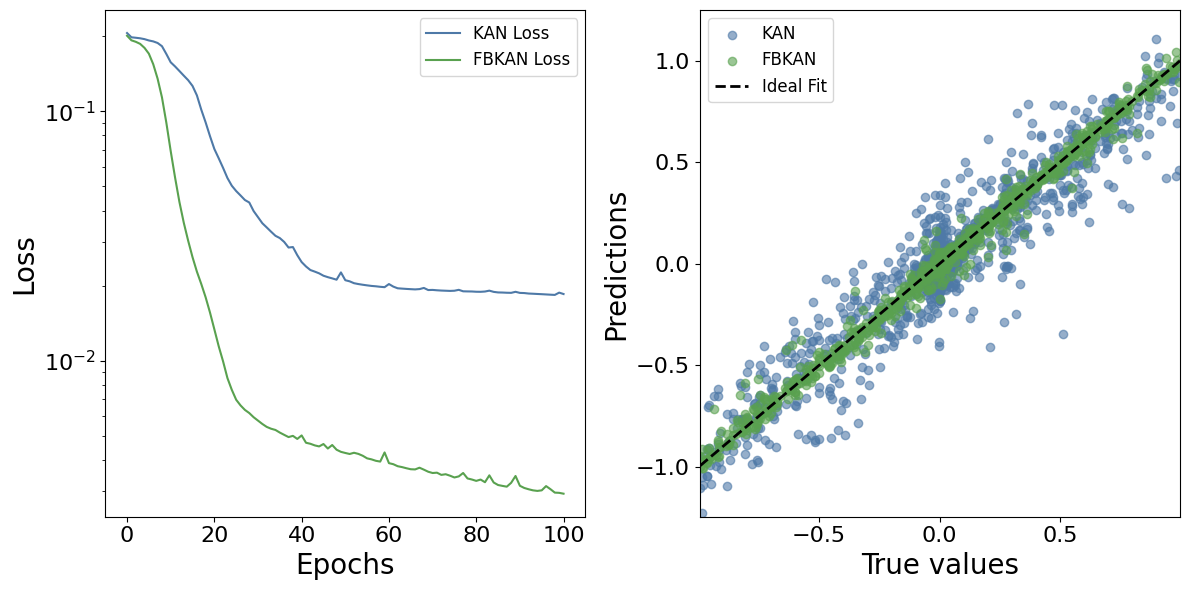

In [89]:
# Plotting results

# Get the losses from the trainers
losses_fbkan = trainer_fbkan.logger.get_losses()
losses_kan = trainer_kan.logger.get_losses()

# # Sort the test data for plotting
sorted_indices = np.argsort(X_test[:, 0].detach().numpy(), axis=0)
X_test_sorted = X_test[sorted_indices].detach().numpy()
z_test_sorted = y_test[sorted_indices].detach().numpy()
z_test_pred_fbkan_sorted = z_test_pred_fbkan[sorted_indices]
z_test_pred_kan_sorted = z_test_pred_kan[sorted_indices]

# Plotting results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(losses_kan['train'], label='KAN Loss', color='#4e79a7')
ax[0].plot(losses_fbkan['train'], label='FBKAN Loss', color='#59a14f')
ax[0].set_xlabel('Epochs', fontsize=20)
ax[0].set_ylabel('Loss', fontsize=20)
ax[0].set_yscale('log')  # Set y-axis to logarithmic scale
ax[0].legend(fontsize=12, ncol=1)
ax[0].tick_params(labelsize=16)

ax[1].scatter(z_test_sorted, z_test_pred_kan_sorted, label='KAN', alpha=0.6, color='#4e79a7')
ax[1].scatter(z_test_sorted, z_test_pred_fbkan_sorted, label='FBKAN', alpha=0.6, color='#59a14f')
ax[1].plot([z_test_sorted.min(), z_test_sorted.max()], [z_test_sorted.min(), z_test_sorted.max()], 'k--', lw=2, label='Ideal Fit')
ax[1].set_xlim([z_test_sorted.min(), z_test_sorted.max()])
ax[1].set_ylim([z_test_sorted.min() - 0.25, z_test_sorted.max() + 0.25])
ax[1].set_xlabel('True values', fontsize=20)
ax[1].set_ylabel('Predictions', fontsize=20)
ax[1].legend(fontsize=12, ncol=1)
ax[1].tick_params(labelsize=16)

plt.tight_layout()


MSE KAN = 0.11529715359210968
MSE FBKAN = 0.009531326591968536


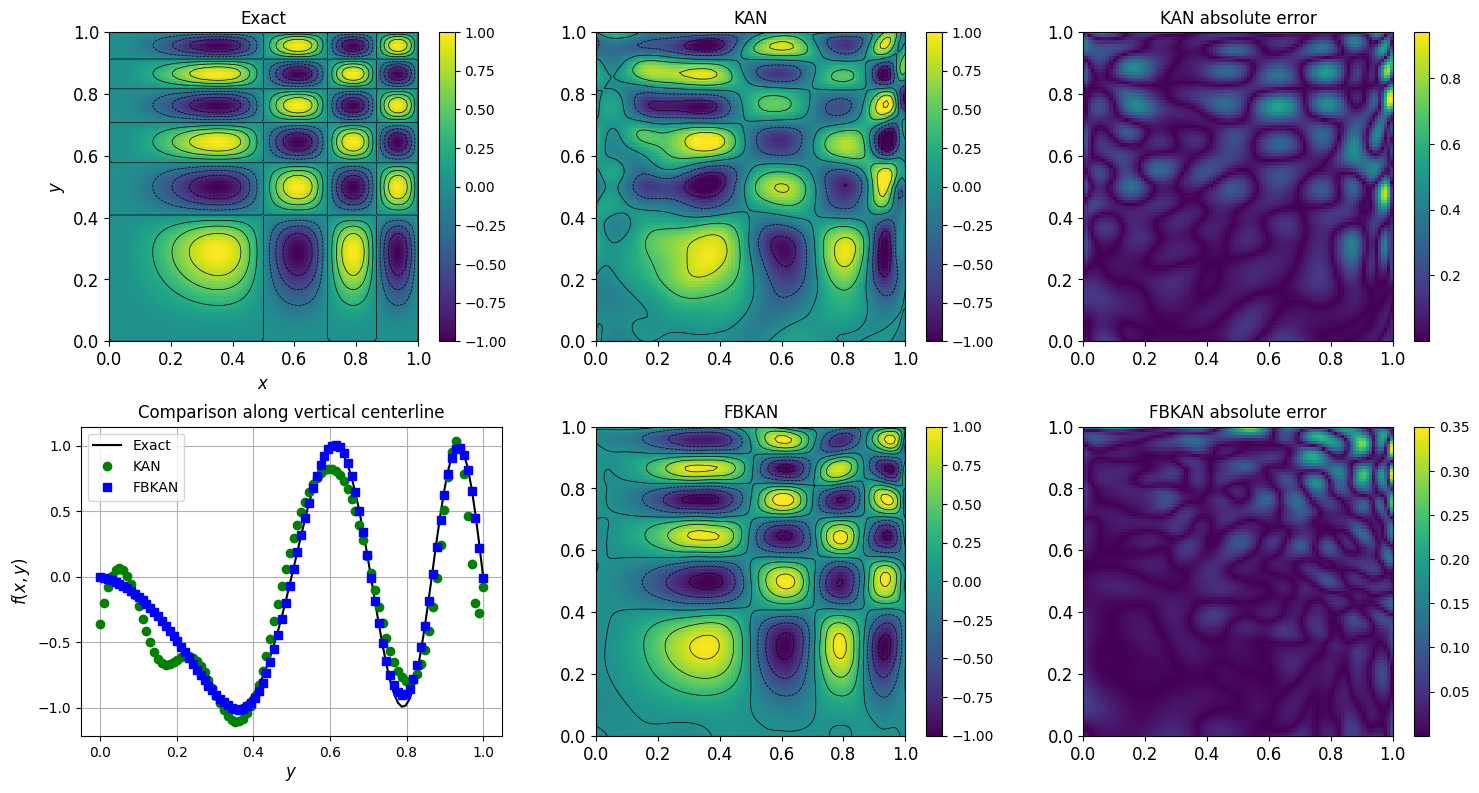

In [108]:

# Create meshgrid
xx = np.linspace(0., 1., 100)
yy = np.linspace(0., 1., 100)
XX, YY = np.meshgrid(xx, yy)

# Create input tensor for the meshgrid points
X_mesh = torch.tensor(np.column_stack((XX.ravel(), YY.ravel())), dtype=torch.float32).to(device)

# Create DictDataset for meshgrid points
mesh_data = DictDataset({'X': X_mesh, 'z': torch.zeros(X_mesh.shape[0], 1)}, name='mesh')

# Perform inference
with torch.no_grad():
    z_mesh_pred_fbkan = trained_model_fbkan(mesh_data.datadict)['z_hat'].cpu().numpy()
    z_mesh_pred_kan = trained_model_kan(mesh_data.datadict)['z_hat'].cpu().numpy()

# Reshape predictions to match meshgrid
z_mesh_pred_fbkan_reshaped = z_mesh_pred_fbkan.reshape(XX.shape)
z_mesh_pred_kan_reshaped = z_mesh_pred_kan.reshape(XX.shape)

# Create true values for comparison (using the original function f)
f = lambda x: ((torch.sin(4*torch.pi*(x[:,[0]]**2))))*((torch.sin(6*torch.pi*(x[:,[1]]**2))))
y_mesh_true = f(X_mesh).cpu().numpy().reshape(XX.shape)

# Calculate errors
error_kan = np.abs(z_mesh_pred_kan_reshaped - y_mesh_true)
error_fbkan = np.abs(z_mesh_pred_fbkan_reshaped - y_mesh_true)

# Create the plots
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

minc = -1.
maxc = 1.

cmap = plt.get_cmap('viridis')

# Plotting exact values with isocontour lines
p = ax[0, 0].pcolor(XX, YY, y_mesh_true, vmin=minc, vmax=maxc, cmap=cmap)
fig.colorbar(p, ax=ax[0, 0])
ax[0, 0].contour(XX, YY, y_mesh_true, colors='k', linewidths=0.5)
ax[0, 0].set_xlim([XX.min(), XX.max()])
ax[0, 0].set_ylim([YY.min(), YY.max()])
ax[0, 0].set_xlabel('$x$', fontsize=12)
ax[0, 0].set_ylabel('$y$', fontsize=12)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].set_title('Exact', fontsize=12)
ax[0, 0].set_aspect('equal')

# Plotting KAN predictions with isocontour lines
p = ax[0, 1].pcolor(XX, YY, z_mesh_pred_kan_reshaped, vmin=minc, vmax=maxc, cmap=cmap)
fig.colorbar(p, ax=ax[0, 1])
ax[0, 1].contour(XX, YY, z_mesh_pred_kan_reshaped, colors='k', linewidths=0.5)
ax[0, 1].set_xlim([XX.min(), XX.max()])
ax[0, 1].set_ylim([YY.min(), YY.max()])
ax[0, 1].tick_params(labelsize=12)
ax[0, 1].set_title('KAN', fontsize=12)
ax[0, 1].set_aspect('equal')

# Plotting FBKAN predictions with isocontour lines
p = ax[1, 1].pcolor(XX, YY, z_mesh_pred_fbkan_reshaped, vmin=minc, vmax=maxc, cmap=cmap)
fig.colorbar(p, ax=ax[1, 1])
ax[1, 1].contour(XX, YY, z_mesh_pred_fbkan_reshaped, colors='k', linewidths=0.5)
ax[1, 1].set_xlim([XX.min(), XX.max()])
ax[1, 1].set_ylim([YY.min(), YY.max()])
ax[1, 1].tick_params(labelsize=12)
ax[1, 1].set_title('FBKAN', fontsize=12)
ax[1, 1].set_aspect('equal')

# Plotting KAN error without isocontour lines
p = ax[0, 2].pcolor(XX, YY, error_kan, cmap=cmap)
fig.colorbar(p, ax=ax[0, 2])
ax[0, 2].set_xlim([XX.min(), XX.max()])
ax[0, 2].set_ylim([YY.min(), YY.max()])
ax[0, 2].tick_params(labelsize=12)
ax[0, 2].set_title('KAN absolute error', fontsize=12)
ax[0, 2].set_aspect('equal')

# Plotting FBKAN error without isocontour lines
p = ax[1, 2].pcolor(XX, YY, error_fbkan, cmap=cmap)
fig.colorbar(p, ax=ax[1, 2])
ax[1, 2].set_xlim([XX.min(), XX.max()])
ax[1, 2].set_ylim([YY.min(), YY.max()])
ax[1, 2].tick_params(labelsize=12)
ax[1, 2].set_title('FBKAN absolute error', fontsize=12)
ax[1, 2].set_aspect('equal')

# Plot error comparison along the y-axis
x_mid_index = XX.shape[0] // 2  # Get the middle index along the y-axis
ax[1, 0].plot(yy, y_mesh_true[x_mid_index, :], '-k', label='Exact')
ax[1, 0].plot(yy, z_mesh_pred_kan_reshaped[x_mid_index, :], 'og', label='KAN')
ax[1, 0].plot(yy, z_mesh_pred_fbkan_reshaped[x_mid_index, :],'sb', label='FBKAN')
ax[1, 0].set_xlabel('$y$', fontsize=12)
ax[1, 0].set_ylabel('$f(x,y)$', fontsize=12)
ax[1, 0].legend()
ax[1, 0].set_title('Comparison along vertical centerline', fontsize=12)
ax[1, 0].grid()

print(f'MSE KAN = {np.mean((y_test.cpu().numpy() - z_test_pred_kan)**2) / np.mean(y_test.cpu().numpy()**2)}')
print(f'MSE FBKAN = {np.mean((y_test.cpu().numpy() - z_test_pred_fbkan)**2) / np.mean(y_test.cpu().numpy()**2)}')

plt.tight_layout()
plt.show()

